In [1]:
import  matplotlib.pyplot as plt
import numpy as np 


import seaborn as sns
from global_land_mask import globe

from scipy import interpolate



from netCDF4 import Dataset

import tensorflow as tf


# Data Analysis

Historical Climate Observation and Stimulation Dataset is provided by Institute for Climate and Application Research(ICAR). \
There is historical stimulation data by CMIP5/6 mode and historical assimilated observation data by American SODA mode in nearly 100 years. \
Each sample contains the following meteorological and spatiotemporal variables: \
SST (SST), Heat Content Anomaly (T300) (T300), Zonal Wind Anomaly (Ua), and Meridional Wind Anomaly (Va). \
The data dimensions are (year,month, Lat, Lon). For the training data, the Nino3.4 Index tag data of the corresponding month shall be provided.

In [2]:
cmip_train = Dataset('/Users/sunjie/TIANCHI/data/CMIP_train.nc')
cmip_label = Dataset('/Users/sunjie/TIANCHI/data/CMIP_label.nc')
soda_train = Dataset('/Users/sunjie/TIANCHI/data/SODA_train.nc')
soda_label = Dataset('/Users/sunjie/TIANCHI/data/SODA_label.nc')

The dimensions of soda_label are 2, they are year and month, the size of 2 dimensions are 100 and 36 separately

In [3]:
soda_label

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): year(100), month(36)
    variables(dimensions): float64 nino(year, month), int32 year(year), int32 month(month)
    groups: 

# Temporal 

In [4]:
soda_label= soda_label['nino'][:,0]

In [26]:
mode_soda=[]
for i in range(0,len(soda_label),100):
    mode_soda.append(soda_label[i:i+100])

In [20]:
soda_label =[soda_label[0]] + [soda_label[i, 24:] for i in range(1, soda_label.shape[0])]

In [8]:
soda_label = np.concatenate(soda_label,axis=0)
soda_label.shape

(1224,)

Label data of CMIP (SODA)_train.nc is sliding mean of Nino3.4 SST’s current abnormal index in 3 months, and the El Niño events identified using 0.5°C threshold, the blue line means value within .5°C,vice versa.

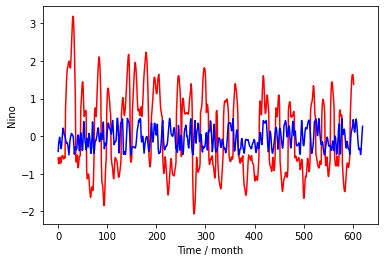

In [15]:
nino_label = soda_label.copy()
non_nino_label = soda_label.copy()

#nino_label[nino_label >= abs(0.5)] = np.nan
#non_nino_label[non_nino_label < abs(0.5)] 

#plt.style.use('fivethirtyeight')
plt.plot(nino_label[abs(nino_label) >= 0.5], color='r')
plt.plot(non_nino_label[abs(non_nino_label) < 0.5], color='b')

plt.xlabel('Time / month')
plt.ylabel('Nino Index')
plt.show()

From 1- 2265 samples, there are 15 simulation data under cmip6 mode, thus I plot each simulation separately.          

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

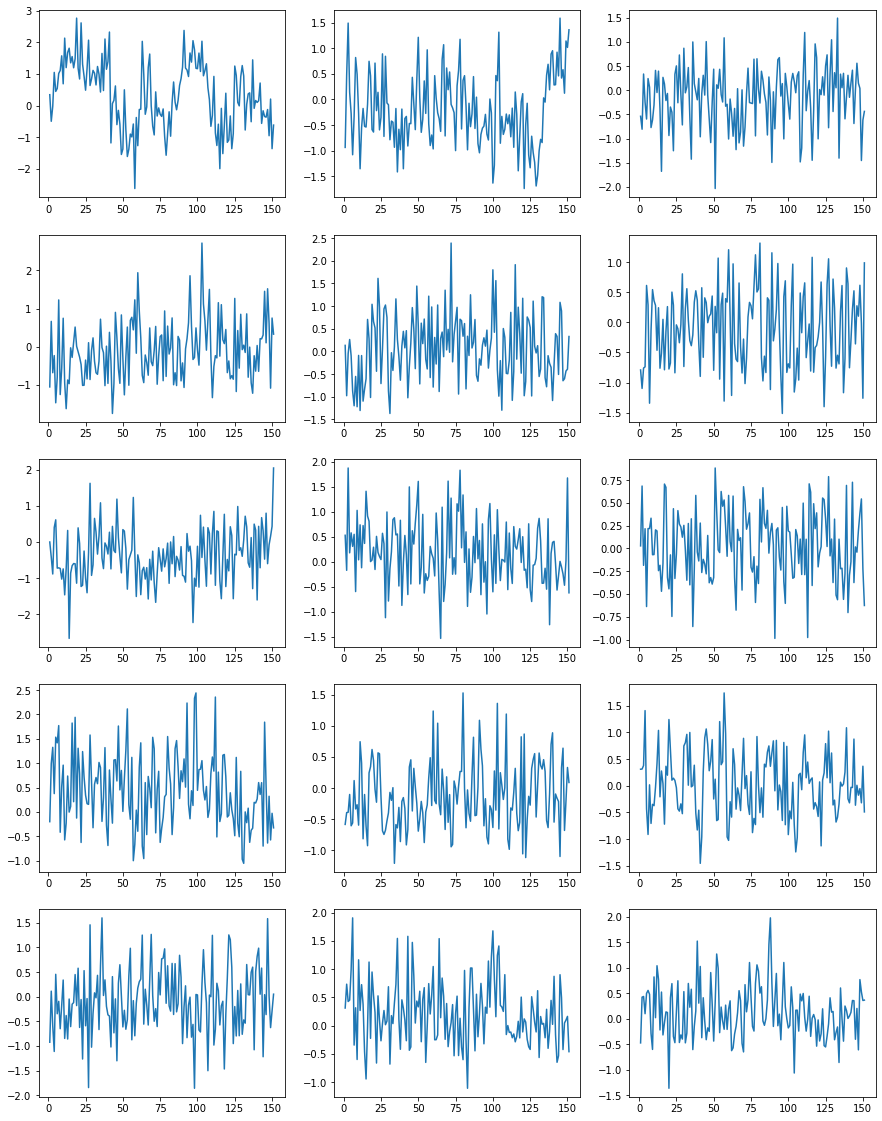

In [37]:
sst = cmip_train['sst']
sst_cmip6=sst[0:2265,0,0,0]
mode_15=[]
for i in range(0,len(sst_cmip6),151):
    mode_15.append(sst_cmip6[i:i+151])
    

plt.figure(figsize=(15, 20))
for i in range(15):
    plt.subplot(5,3,i+1)
    plt.plot(list(range(1,151+1)),mode_15[i])

plt.tight_layout

Same process for cmip5.

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

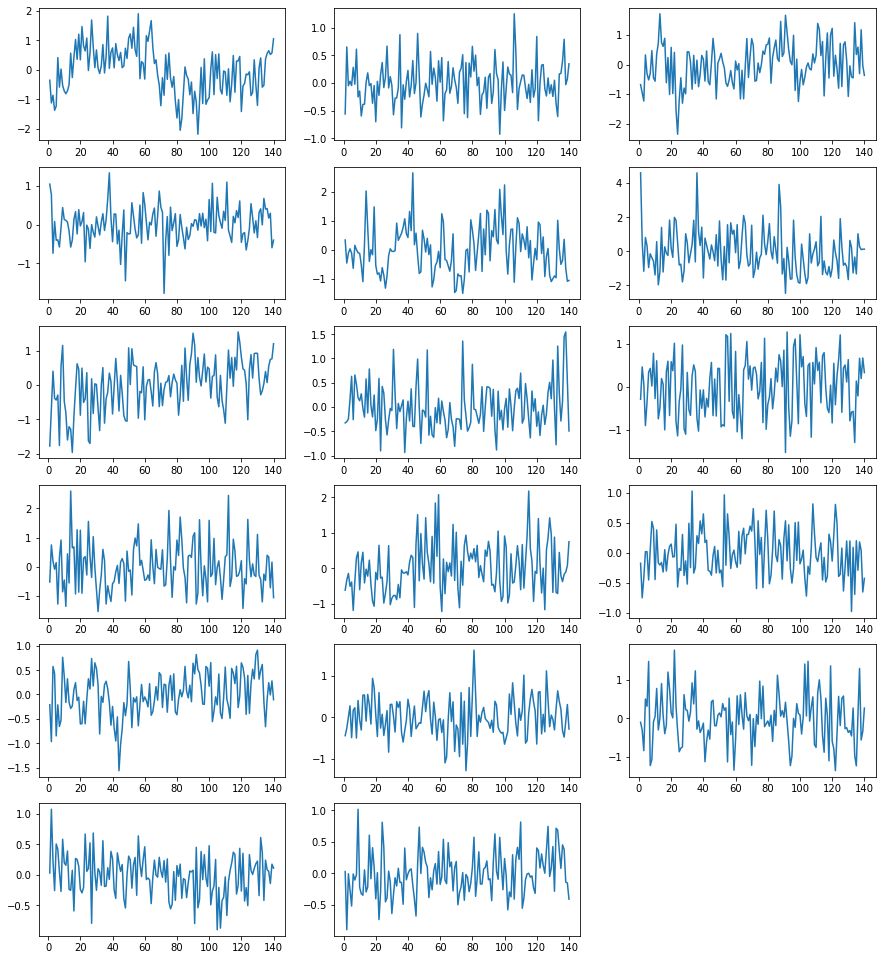

In [36]:

sst_cmip5=sst[2265:,0,0,0]
mode_17=[]
for i in range(0,len(sst_cmip5),140):
    mode_17.append(sst_cmip5[i:i+140])
    

plt.figure(figsize=(15, 20))
for i in range(17):
    plt.subplot(7,3,i+1)
    plt.plot(list(range(1,140+1)),mode_17[i])

plt.tight_layout

# Spatio

In [78]:

lon = np.array(soda_train.variables['lon'])
lat = np.array(soda_train.variables['lat'])
#x = lon
#y = lat
lonl,latl  = np.meshgrid(lon, lat)
z = soda_train.variables['sst'][0,0]
f = interpolate.interp2d(lon, lat, z, kind='cubic')

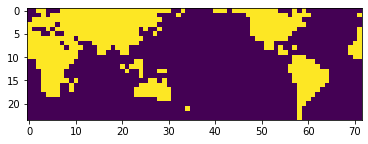

In [81]:
lon_grid, lat_grid = np.meshgrid(lon-180, lat)
# Check if a point is on land:
is_on_land = globe.is_land(lat_grid, lon_grid)
is_on_land = np.concatenate([is_on_land[:,lon>=180], is_on_land[:,lon<180]], axis=1)
z[is_on_land] = np.nan
plt.imshow(is_on_land[::-1,:])

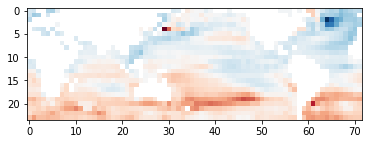

In [82]:
plt.imshow(z[::-1,:], cmap=plt.cm.RdBu_r)

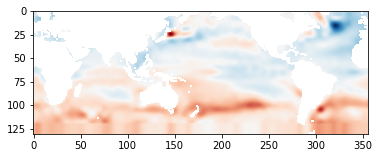

In [83]:
lon_new = np.arange(0,356,1)
lat_new = np.arange(-65,66,1)
z_new = f(lon_new, lat_new)

lon_grid, lat_grid = np.meshgrid(lon_new-180, lat_new)
# Check if a point is on land:
is_on_land = globe.is_land(lat_grid, lon_grid)
is_on_land = np.concatenate([is_on_land[:,lon_new>=180], is_on_land[:,lon_new<180]], axis=1)
z_new[is_on_land] = np.nan
plt.imshow(z_new[::-1,:], cmap=plt.cm.RdBu_r)#is_on_land[:,:])

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

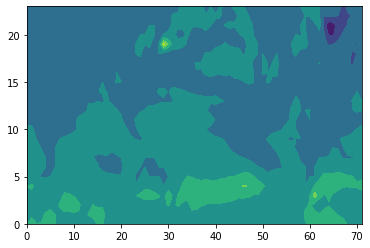

In [105]:
plt.contourf(sst[0,0,:,:])

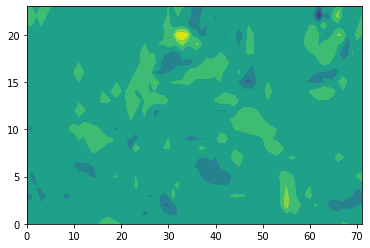

In [39]:
plt.contourf(t300[0,0,:,:])

In [23]:
latvals =lat[:];lonvals =lon[:]


In [213]:
my_list = [10, 20, 30, 40, 50, 60] 
print(my_list[::-1]) 
print(my_list[:3])
print(my_list[4:])

[60, 50, 40, 30, 20, 10]
[10, 20, 30]
[50, 60]


In [54]:
a=[1,2,3,4,5,6,7,8,9,10,11,12,13,14]
b=[]
for i in range(0, len(a), 3):
    b.append(a[i:i+3])
print (b)

[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14]]


In [55]:
range(4)

range(0, 4)

In [56]:
for i in range(4, 10, 2):
     print(i)

4
6
8


In [73]:
list (range(1,10+1))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
#使用list生成
list1 = list(range(1,100+1))
print(list1)

#使用列表生成式
list2 = [i for i in range(1,100+1)]
print(list2)

#使用for循环
list3 = []
for i in range(1,100+1):
    list3.append(i)
print(list3)


In [176]:

#n1, n2 = (5, 3)
a = np.linspace(1, 15, 15)
b = np.linspace(20, 30, 10)
aa, bb = np.meshgrid(a, b)



In [178]:
aa

array([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.]])

In [179]:
bb

array([[20.        , 20.        , 20.        , 20.        , 20.        ,
        20.        , 20.        , 20.        , 20.        , 20.        ,
        20.        , 20.        , 20.        , 20.        , 20.        ],
       [21.11111111, 21.11111111, 21.11111111, 21.11111111, 21.11111111,
        21.11111111, 21.11111111, 21.11111111, 21.11111111, 21.11111111,
        21.11111111, 21.11111111, 21.11111111, 21.11111111, 21.11111111],
       [22.22222222, 22.22222222, 22.22222222, 22.22222222, 22.22222222,
        22.22222222, 22.22222222, 22.22222222, 22.22222222, 22.22222222,
        22.22222222, 22.22222222, 22.22222222, 22.22222222, 22.22222222],
       [23.33333333, 23.33333333, 23.33333333, 23.33333333, 23.33333333,
        23.33333333, 23.33333333, 23.33333333, 23.33333333, 23.33333333,
        23.33333333, 23.33333333, 23.33333333, 23.33333333, 23.33333333],
       [24.44444444, 24.44444444, 24.44444444, 24.44444444, 24.44444444,
        24.44444444, 24.44444444, 24.44444444, 

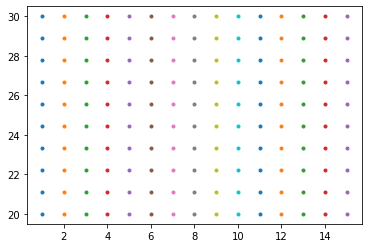

In [186]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(aa,bb,ls = "None",marker=".")
plt.show()


In [188]:
R = np.linspace(1,5,10)
THETA = np.linspace(0,np.pi,45)
radii, thetas = np.meshgrid(R, THETA)
print("R:{}".format(R.shape))
print("THETA:{}".format(THETA.shape))
print("meshgrid thetas:{}".format(thetas.shape))

R:(10,)
THETA:(45,)
meshgrid thetas:(45, 10)


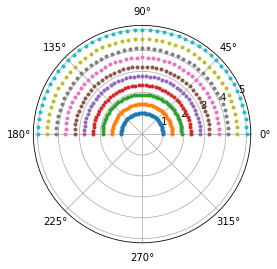

In [189]:
ax1 = plt.subplot(111,polar = True)
ax1.plot(thetas,radii,marker='.',ls='none')
plt.show()

In [169]:
x = [1,2,3,4,5]

In [170]:
y = [9,8,7]

In [172]:
np.meshgrid(x,y)

[array([[1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5],
        [1, 2, 3, 4, 5]]),
 array([[9, 9, 9, 9, 9],
        [8, 8, 8, 8, 8],
        [7, 7, 7, 7, 7]])]

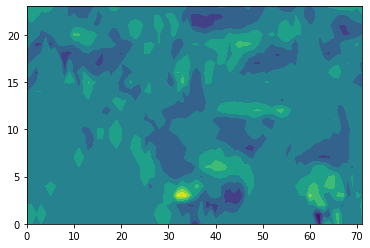

2265

<class 'netCDF4._netCDF4.Dimension'>: name = 'year', size = 4645

In [88]:
sst.dimensions,sst.shape

(('year', 'month', 'lat', 'lon'), (4645, 36, 24, 72))

In [71]:
sst_year_cmip6 = sst[:2265]
sst_year_cmip6 = sst[2266:]

[   1    2    3 ... 4643 4644 4645]


In [91]:
cmip.variables['year']

<class 'netCDF4._netCDF4.Variable'>
int32 year(year)
unlimited dimensions: 
current shape = (4645,)
filling on, default _FillValue of -2147483647 used

<Figure size 432x288 with 0 Axes>

In [34]:
ax = fig.add_subplot(1,1,1)

In [37]:
import numpy as np

In [ ]:
ax.set_xticks(year)

1-2265 are 151 years historical simulation data provided by 15 models of CMIP6 (totally: 151 years *15 models =2265)

In [60]:
year_CMIP6 = year[:2265]

In [61]:
year_CMIP6

masked_array(data=[   1,    2,    3, ..., 2263, 2264, 2265],
             mask=False,
       fill_value=999999,
            dtype=int32)

2266-4645 are 140 years historical simulation data provided by 17 modes of CMIP5 (totally: 140 years *17 modes =2380)

In [62]:
year_CMIP5 = year[2266:]

In [63]:
year_CMIP5

masked_array(data=[2267, 2268, 2269, ..., 4643, 4644, 4645],
             mask=False,
       fill_value=999999,
            dtype=int32)

In [64]:
month

masked_array(data=[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
                   15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
                   29, 30, 31, 32, 33, 34, 35, 36],
             mask=False,
       fill_value=999999,
            dtype=int32)

In [66]:
len(sst)

4645